In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from gdrive.MyDrive.ERA.S7.model_4 import Network

In [2]:
# Create simple transform and calculate mean and std dev.
simple_transforms = transforms.Compose([
    transforms.ToTensor()
])
exp = datasets.MNIST('./data', train = True, download = True, transform = simple_transforms)
exp_data = exp.transform(exp.data.numpy())

print("EXP")
print(' - Numpy Shape:', exp.data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))


100%|██████████| 9912422/9912422 [00:00<00:00, 95735907.53it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 38443571.51it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32433190.60it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19439315.07it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

EXP
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


In [3]:
#Prepare basic transforms using mean and std from above.
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])

In [4]:
#Download data
train = datasets.MNIST('./data', train = True, download = True, transform = train_transforms)
test = datasets.MNIST('./data', train = False, download = True, transform = test_transforms)

In [5]:
# Create data loader

SEED = 4

cuda = torch.cuda.is_available()
print("CUDA available: ", cuda)

torch.manual_seed(SEED)

if cuda:
  torch.cuda.manual_seed(SEED)

# dataloader args would be user input
dataloader_args = dict(shuffle = True, batch_size = 128, num_workers = 2, pin_memory = True) if cuda else dict(shuffle = True, batch_size = 128)

# Train loader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# Test loader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)



CUDA available:  True


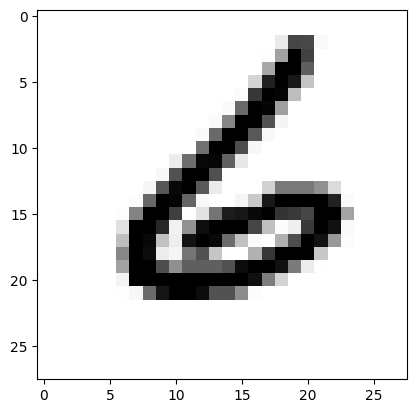

In [ ]:
# Data visualization
dataiter = iter(train_loader)
images, labels = next(dataiter)

plt.imshow(images[0].squeeze(), cmap='gray_r')

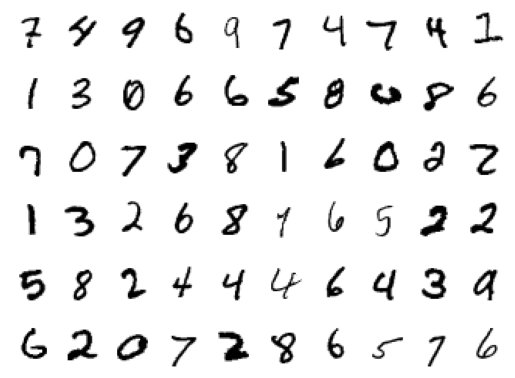

In [ ]:
# check data to decide correct transforms needed.
# figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [7]:
# Model summary

!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Network().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             144
       BatchNorm2d-2           [-1, 16, 28, 28]              32
              ReLU-3           [-1, 16, 28, 28]               0
         Dropout2d-4           [-1, 16, 28, 28]               0
            Conv2d-5           [-1, 16, 28, 28]           2,304
       BatchNorm2d-6           [-1, 16, 28, 28]              32
              ReLU-7           [-1, 16, 28, 28]               0
         Dropout2d-8           [-1, 16, 28, 28]               0
            Conv2d-9           [-1, 10, 28, 28]             160
        MaxPool2d-10           [-1, 10, 14, 14]               0
           Conv2d-11           [-1, 10, 14, 14]             900
      BatchNorm2d-12           [-1, 10, 14, 14]              20
             ReLU-13           [-1, 10, 14, 14]               0
        Dropout2d-14           [-1

In [8]:
# Training and Testing code
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [15]:
# Running the model
model =  Network().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.2, verbose=True)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

EPOCH: 0


Loss=0.10272622853517532 Batch_id=468 Accuracy=89.14: 100%|██████████| 469/469 [00:15<00:00, 29.75it/s]



Test set: Average loss: 0.0560, Accuracy: 9810/10000 (98.10%)

EPOCH: 1


Loss=0.0913061797618866 Batch_id=468 Accuracy=96.74: 100%|██████████| 469/469 [00:15<00:00, 29.55it/s]



Test set: Average loss: 0.0391, Accuracy: 9871/10000 (98.71%)

EPOCH: 2


Loss=0.050535429269075394 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:15<00:00, 29.72it/s]



Test set: Average loss: 0.0321, Accuracy: 9901/10000 (99.01%)

EPOCH: 3


Loss=0.06875056028366089 Batch_id=468 Accuracy=97.68: 100%|██████████| 469/469 [00:16<00:00, 28.04it/s]



Test set: Average loss: 0.0284, Accuracy: 9892/10000 (98.92%)

EPOCH: 4


Loss=0.03217945620417595 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:16<00:00, 27.69it/s]



Test set: Average loss: 0.0228, Accuracy: 9915/10000 (99.15%)

EPOCH: 5


Loss=0.043441418558359146 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:16<00:00, 28.68it/s]



Test set: Average loss: 0.0227, Accuracy: 9918/10000 (99.18%)

EPOCH: 6


Loss=0.04467938467860222 Batch_id=468 Accuracy=98.34: 100%|██████████| 469/469 [00:15<00:00, 29.46it/s]



Test set: Average loss: 0.0211, Accuracy: 9919/10000 (99.19%)

EPOCH: 7


Loss=0.013936654664576054 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:15<00:00, 29.93it/s]



Test set: Average loss: 0.0203, Accuracy: 9935/10000 (99.35%)

EPOCH: 8


Loss=0.14611411094665527 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:15<00:00, 29.66it/s]



Test set: Average loss: 0.0202, Accuracy: 9932/10000 (99.32%)

EPOCH: 9


Loss=0.05097297951579094 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:15<00:00, 29.53it/s]



Test set: Average loss: 0.0205, Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Loss=0.1062903106212616 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:16<00:00, 28.23it/s]



Test set: Average loss: 0.0200, Accuracy: 9930/10000 (99.30%)

EPOCH: 11


Loss=0.012724783271551132 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:15<00:00, 29.61it/s]



Test set: Average loss: 0.0198, Accuracy: 9933/10000 (99.33%)

EPOCH: 12


Loss=0.03087327443063259 Batch_id=468 Accuracy=98.55: 100%|██████████| 469/469 [00:17<00:00, 26.53it/s]



Test set: Average loss: 0.0198, Accuracy: 9930/10000 (99.30%)

EPOCH: 13


Loss=0.014702185057103634 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:15<00:00, 29.35it/s]



Test set: Average loss: 0.0199, Accuracy: 9933/10000 (99.33%)

EPOCH: 14


Loss=0.04757240414619446 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:16<00:00, 27.84it/s]



Test set: Average loss: 0.0201, Accuracy: 9935/10000 (99.35%)

EPOCH: 15


Loss=0.024341821670532227 Batch_id=468 Accuracy=98.52: 100%|██████████| 469/469 [00:16<00:00, 29.21it/s]



Test set: Average loss: 0.0200, Accuracy: 9928/10000 (99.28%)

EPOCH: 16


Loss=0.12293741106987 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:16<00:00, 28.81it/s]



Test set: Average loss: 0.0200, Accuracy: 9931/10000 (99.31%)

EPOCH: 17


Loss=0.0637560710310936 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:17<00:00, 26.28it/s]



Test set: Average loss: 0.0198, Accuracy: 9932/10000 (99.32%)

EPOCH: 18


Loss=0.053278982639312744 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:19<00:00, 24.36it/s]



Test set: Average loss: 0.0199, Accuracy: 9933/10000 (99.33%)

EPOCH: 19


Loss=0.03932017460465431 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:21<00:00, 22.00it/s]



Test set: Average loss: 0.0201, Accuracy: 9933/10000 (99.33%)



Text(0.5, 1.0, 'Test Accuracy')

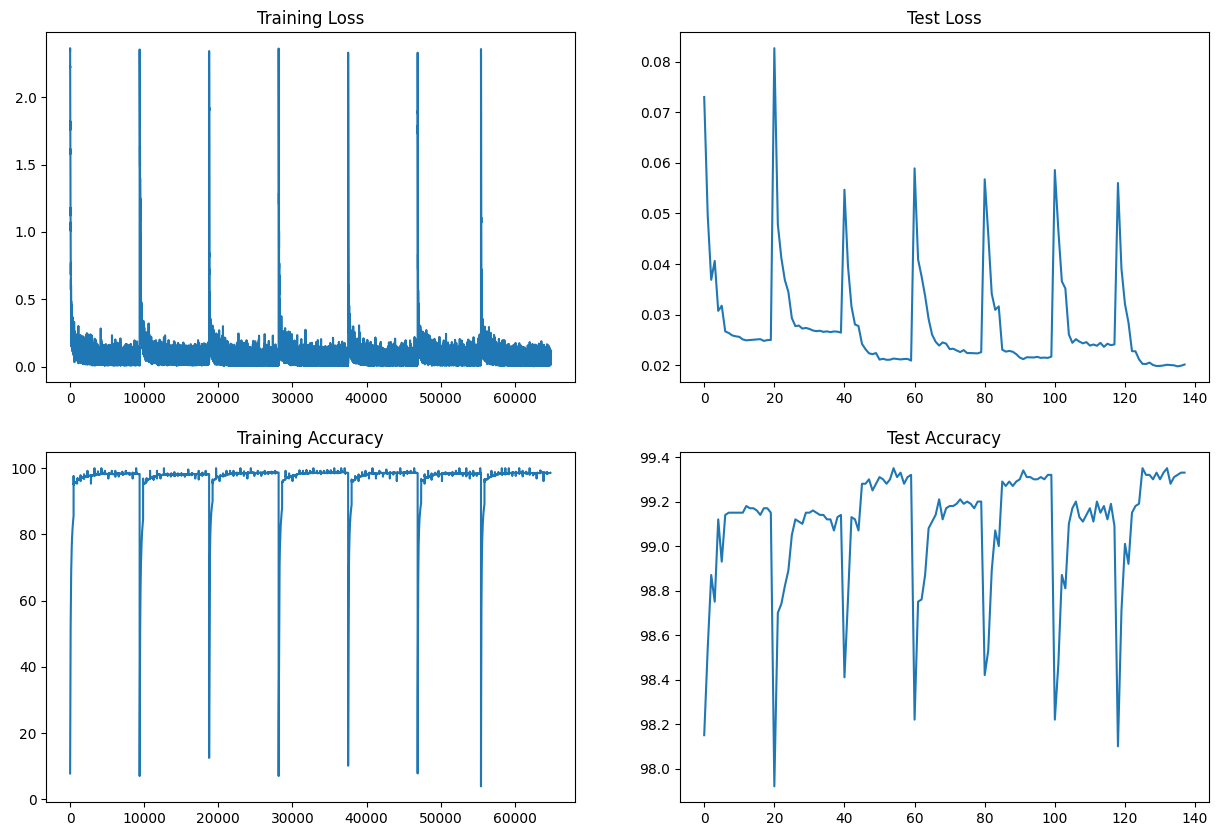

In [16]:
# Plot the training and test loss and accuracy
t = [t_items.item() for t_items in train_losses]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# Target:


1. Improve accuracy by adjusting learning rate.

# Result

(considering only first 15 epochs)
1. Total params: 7,580
2. Best training accuracy: 98.58% (Epoch - 11)
3. Best test accuracy: 99.35% (Epoch - 7)



# Analysis



1. [Model](https://github.com/walnashgit/ERAV2/blob/main/S7/model3/model_3.py)
2. No overfitting is there.
3. Model accuracy seems to have stablized around 99.35%.
4. Increasing capacity and some modification to architecture may help improving the accuracy.





